In [1]:
import pandas as pd
def getPt(inpath, station, network, channel):
    df = pd.read_csv(f"{inpath}/arrivals.txt", header = None, delim_whitespace=True, skiprows = 1, names=[ "network", "station", 
                                                                                        "channel", "two-digit location code", 
                                                                                        "latitude", "longitude", "elevation", 
                                                                                        "phase", "first- motion", "signal onset quality", 
                                                                                        "pick quality", "epicentral distance",  
                                                                                        "time after origin time"])
    nsc = df.loc[(df['station'] == station) & (df['network'] == network) & (df['phase'] == "P")]
    #print(df)
    #print(station, network, channel)
    with open(f'{inpath}/arrivals.txt') as f:
        first_line = f.readline()
    evt_id = first_line.split()[0]
    if len(nsc["time after origin time"]) == 0:
        print("no hand picked wave time")
        return [evt_id, False]
    else:
        t = nsc["time after origin time"].iloc[0]
        #print("t", t)
        return [evt_id, t]

progress: [23, 105, 45, 514, 'CI.CWP.', '20220118084437210']
depth:  12.51
distance (degrees):  0.72657
sPn: 0 arrivals
	
sPmP: 1 arrivals
	sPvmP phase arrival at 19.527 seconds
TP=13.348s    TsPn=nans TsPmP=19.545s


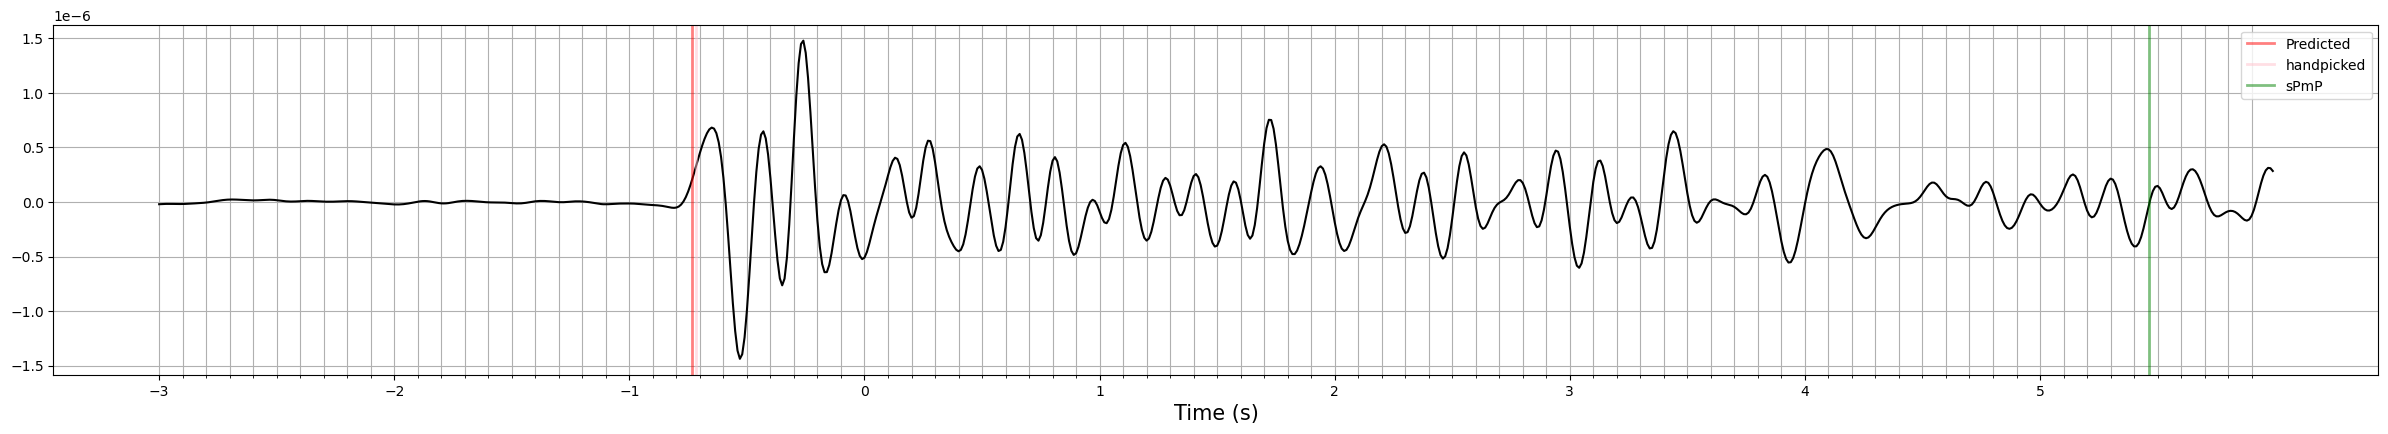

In [ ]:
#  refine P-wave arrival and calculate theoretical sP-P differential time
import os
import glob
import obspy
import time
from obspy.taup import TauPyModel
from obspy.clients.iris import Client
client = Client()
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.trigger import classic_sta_lta
from IPython.display import clear_output
switch1 = True
switch2 = True

data_sac="./Download/SAC"
file = open("./judge.info", "a")
file.close()
file2 = open("./progression.info", "r")

overall_progress = file2.read().split()
evt = overall_progress[1]
sacfile_name = overall_progress[0]


file2.close()
total = len(os.listdir(data_sac))
events = os.listdir(data_sac)
for ev in events:
        #print(ev)
        if ev != evt and switch1 == True:
            continue
        switch1 = False

        inpath = os.path.join(data_sac, ev)
        if len(glob.glob(f"{inpath}/*R.SAC.bp.cut")) == 0:
            continue
        else:            
            funiq = []
            for sac in glob.glob(f"{inpath}/*R.SAC.bp.cut"):
                st = obspy.read(sac)
                funiq.append("{}.{}.{}".format(st[0].stats.network,st[0].stats.station,st[0].stats.location))
            fU = sorted(set(funiq))
            subTotal = len(fU)
           
            for sacfile in fU:
                iteration2 = iter(fU)
                
                if switch2 == True and sacfile != sacfile_name:
                    continue
                switch2 = False
                
                
                        
                progress = [fU.index(sacfile), len(fU), events.index(ev), len(events), sacfile, ev]
                print("progress:", progress)
                file2 = open("./progression.info", "w")
                file2.write(f" {sacfile} {ev}")
                file2.close()
                
                st = obspy.read(f"{inpath}/{sacfile}*[RTZ].SAC.bp.cut")
                
                #get hand-picked time
                network = st[0].stats.network
                station = st[0].stats.station
                channel = st[0].stats.channel
                
                handpick_info = getPt(inpath, station, network, channel)
                handpick_Tp = handpick_info[1]
                
                evt_id = handpick_info[0]
                shift = st[0].stats.sac.o
                #print(shift)

                ### refine P-wave arrival using sta/lta method
                df = st[0].stats.sac.delta
                end_window = 13
                nd_window = 4
                t = np.arange(st[0].stats.sac.t1-3, st[0].stats.sac.t1+end_window, st[0].stats.delta)
                
                
                # time window
                idx1 = int((st[0].stats.sac.t1-3-st[0].stats.sac.b)/st[0].stats.delta)
                idx2 = int((st[0].stats.sac.t1+end_window-st[0].stats.sac.b)/st[0].stats.delta)
                

                ### calculate the theoretical sP-P differential time
                model = TauPyModel(model="./hk.npz")
                sachd = st[0].stats.sac
                distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
                gcarc = distaz['distance']
                
                #print("Event depth: ", sachd["evdp"])
                #print("Distance (degrees): ", gcarc)
                
                if sachd["evdp"] < 0:
                    source_depth = 0
                else:
                    source_depth = sachd["evdp"]
                
                arrival_sPmP = model.get_travel_times(source_depth_in_km=source_depth,
                                                      distance_in_degree=gcarc, 
                                                      phase_list=["sPvmP"]) #vm is used to indicate upper moho reflection
                arrival_P = model.get_travel_times(source_depth_in_km=source_depth,distance_in_degree=gcarc, phase_list=["ttp"])
                #print(arrival_P)
                #print(arrival_sPmP)
                
                if handpick_Tp == False:
                    continue
                    #handpick_Tp = arrival_P[0].time
                    
                try:
                    TsPmP = arrival_sPmP[0].time - arrival_P[0].time+handpick_Tp
                    TsPmP = float("{:.3f}".format(TsPmP))
                except: 
                    print("no sPmP arrival")
                    continue
                print("depth: ", source_depth)
                print("distance (degrees): ", gcarc)
                    
                #fix timewindow to be closer to waveform
                if abs(TsPmP +shift- end_window)>2:
                    end_window = round(TsPmP+shift) +1
#                     start_window = 3
#                     if abs(handpick_Tp +shift- 3)>2:
#                         start_window = round(handpick_Tp +shift) -3
                    t = np.arange(st[0].stats.sac.t1-3, st[0].stats.sac.t1+end_window, st[0].stats.delta)
                    # time window
                    idx1 = int((st[0].stats.sac.t1-3-st[0].stats.sac.b)/st[0].stats.delta)
                    idx2 = int((st[0].stats.sac.t1+end_window-st[0].stats.sac.b)/st[0].stats.delta)
                    
                
                arrival_sPn = model.get_travel_times(source_depth_in_km=source_depth,distance_in_degree=gcarc, phase_list=["sPn"])
                if len(arrival_sPn) != 0:
                    TsPn = arrival_sPn[0].time - arrival_P[0].time+handpick_Tp
                    TsPn = float("{:.3f}".format(TsPn))
                else:
                    TsPn = "nan"
                print("sPn:", arrival_sPn)
                print("sPmP:", arrival_sPmP)
                print("TP={:.3f}s    TsPn={}s TsPmP={:.3f}s".format(arrival_P[0].time,TsPn,TsPmP))

                ### Plot the waveform
                plt.figure(figsize=(30,10))
                plt.subplot(211)
                #plt.xticks(np.arange(min(t), max(t)+0.1, 0.1))
                
                plt.plot(t,st[2].data[idx1:idx2],color="black")
                plt.axvline(x=arrival_P[0].time+shift, color="red", alpha=0.5, linewidth=2,label="Predicted")
                
                if handpick_Tp != 0:
                    plt.axvline(x=handpick_Tp + shift, color="pink", alpha=0.5, linewidth=2,label="handpicked")
                plt.axvline(x=TsPmP + shift, color="green", alpha=0.5, linewidth=2, label="sPmP") 
                    #print("handpicked sPmP altered:", TsPmP-Tp)
                if TsPn != "nan":
                    plt.axvline(x=TsPn+shift, color="cyan", alpha=0.5, linewidth=2, label="sPn")   
                major_ticks = np.arange(min(t), max(t), 1)
                minor_ticks = np.arange(min(t), max(t), 0.1)

                plt.xticks(major_ticks)
                plt.xticks(minor_ticks, minor=True)
                


                plt.grid(which='both')
                plt.legend()

                
                plt.xlabel("Time (s)",fontsize=15)
                plt.show()
                quality = input("Quality: y(good) or n(bad)")
                
                if quality == "y":
                    file = open("./judge.info", "a")
                    file.write("Info: {} {} Tp: {} TsPmP: {} TsPn: {}\n".format(ev, sacfile, handpick_Tp, TsPmP, TsPn))
                    file.close()
                clear_output(wait=True)
                
